In [19]:
from additional_test_set import AdditionalTestSet

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from imblearn.ensemble import BalancedRandomForestClassifier

from simple_ml_models import *
from utils import *
from additional_test_set_visualisation import Visualisation
from dimension_reduction import display_umap_2d_plot, display_pca_2d_plot, display_tsne_2d_plot

In [20]:
train_data_path = "data/SingleCell_new_split/newSplitTrainCounts.tsv"
test_data_path = "data/SingleCell_new_split/newSplitTestBCounts.tsv"
train_classes_path = "data/SingleCell_new_split/newSplitTrainSamples.tsv"
test_classes_path = "data/SingleCell_new_split/newSplitTestBSamples.tsv"
SEED = 42

data_object = AdditionalTestSet(
    train_data_path, test_data_path, train_classes_path, test_classes_path
)
data_object.summary()

Total cells number in train data: 176
CTC cells number in train data: 130
WBC cells number in train data: 38
CTC-WBC cells number in test data: 8

Total cells number in test data: 29154
CTC cells number in test data: 1534
WBC cells number in test data: 27620
CTC-WBC cells number in test data: 0


In [21]:
cut_by_mean_train_data, cut_by_mean_test_data = AdditionalTestSet.cut_data_by_mean(
    data_object.train_data, data_object.test_data, threshold=0.3
)
(
    cut_by_mean_max_train_data,
    cut_by_mean_max_test_data,
) = AdditionalTestSet.cut_data_by_max(
    cut_by_mean_train_data, cut_by_mean_test_data, threshold=5
)
print(f"Feature number: {len(cut_by_mean_max_train_data.columns)}")

Feature number: 67


In [22]:
calculate_global_statistics(cut_by_mean_max_train_data, data_object.train_classes)

CTC mean: 1.3878185937553742
WBC mean: 1.5953677170154843
CTC standard deviation: 1.4652900397345212
WBC standard deviation: 1.6676982620698146
CTC non-zero values: 70.62513519359723 %
WBC non-zero values: 69.87431264728987 %
T-test p-values: 0.00022222264604727357


/home/melehean/miniconda3/envs/gumed/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


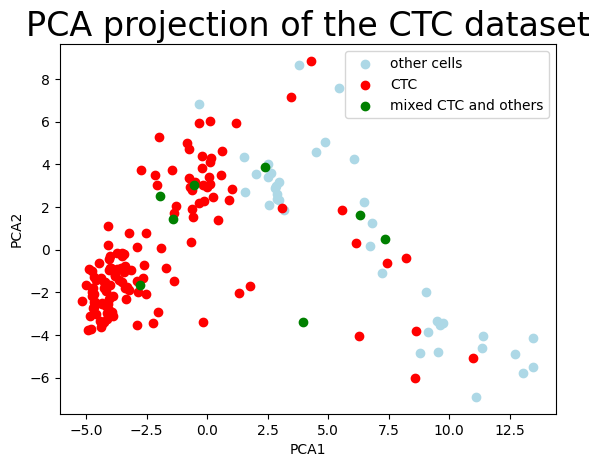

In [23]:
display_pca_2d_plot(cut_by_mean_max_train_data, data_object.train_classes, 42, data_object.train_classes_names)

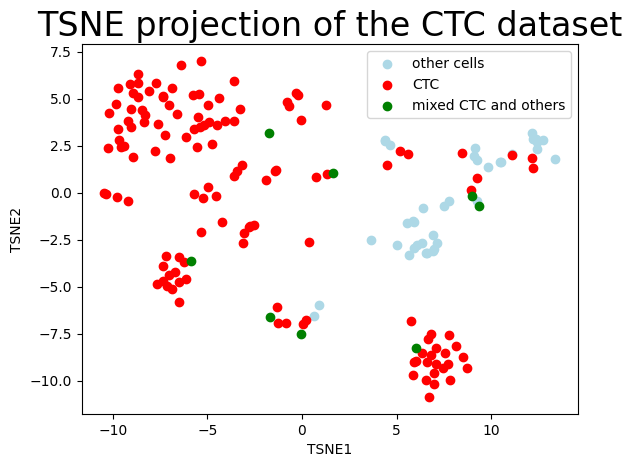

In [24]:
display_tsne_2d_plot(cut_by_mean_max_train_data, data_object.train_classes, 42, data_object.train_classes_names)

In [25]:
cut_by_mean_with_classes_train_data, cut_by_mean_with_classes_test_data = data_object.cut_data_by_mean_with_classes(
    data_object.train_data, data_object.test_data, threshold=1.6
)
print(f"Feature number: {len(cut_by_mean_with_classes_train_data.columns)}")

Feature number: 67


In [26]:
calculate_global_statistics(cut_by_mean_with_classes_train_data, data_object.train_classes)

CTC mean: 2.183716460783793
WBC mean: 2.3405462298330475
CTC standard deviation: 1.0421085708740032
WBC standard deviation: 1.1590088328941146
CTC non-zero values: 95.18710793856803 %
WBC non-zero values: 94.10840534171248 %
T-test p-values: 3.004350923767403e-16


/home/melehean/miniconda3/envs/gumed/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


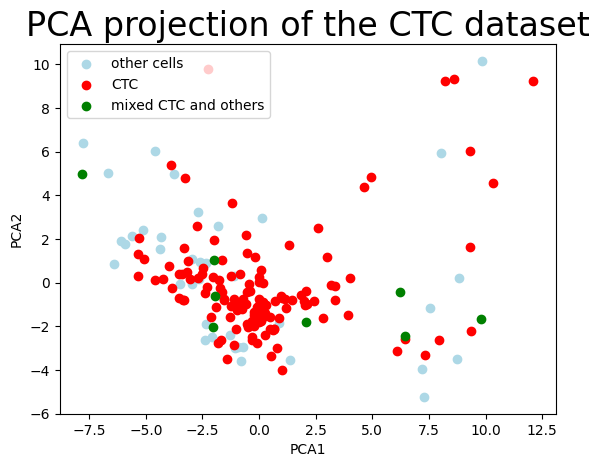

In [27]:
display_pca_2d_plot(cut_by_mean_with_classes_train_data, data_object.train_classes, 42, data_object.train_classes_names)

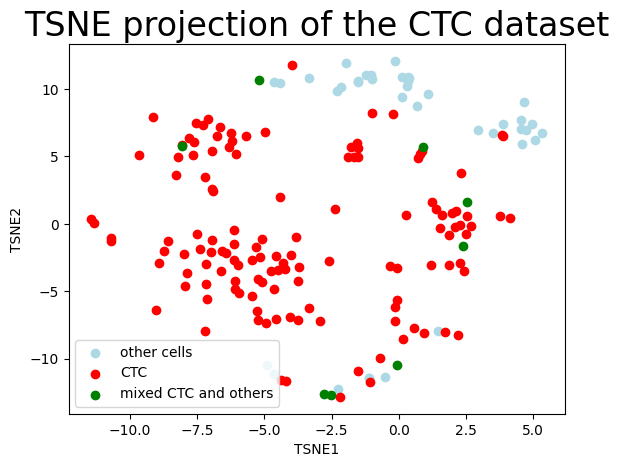

In [28]:
display_tsne_2d_plot(cut_by_mean_with_classes_train_data, data_object.train_classes, 42, data_object.train_classes_names)

### LightGBM

In [29]:
lgbm_clf = LGBMClassifier(
    boosting_type="gbdt",
    min_child_weight=0.01,
    max_depth=10,
    num_leaves=16,
    n_estimators=2000,
    subsample_for_bin=10000,
    is_unbalance=True,
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [30]:
lgbm_model_object = Model(
    lgbm_clf,
    cut_by_mean_max_train_data,
    data_object.train_classes,
    cut_by_mean_max_test_data,
    data_object.test_classes,
    3,
)
lgbm_estimators = lgbm_model_object.main_cycle()


Validation balanced accuracy 0.9248420661464141
Training balanced accuracy 1.0

Validation roc auc 0.9801653660349312
Training roc auc 1.0

Validation precision 0.9703488788595171
Training precision 1.0

Validation recall 0.9565217391304347
Training recall 1.0

Validation f1 0.9632045373980858
Training f1 1.0



In [31]:
lgbm_model_object.display_test_results()


Test balanced accuracy 0.8755228105023759

Test roc auc 0.9791841440345963

Test precision 0.27204793037651603

Test recall 0.9850065189048239

Test f1 score 0.40020514617148856


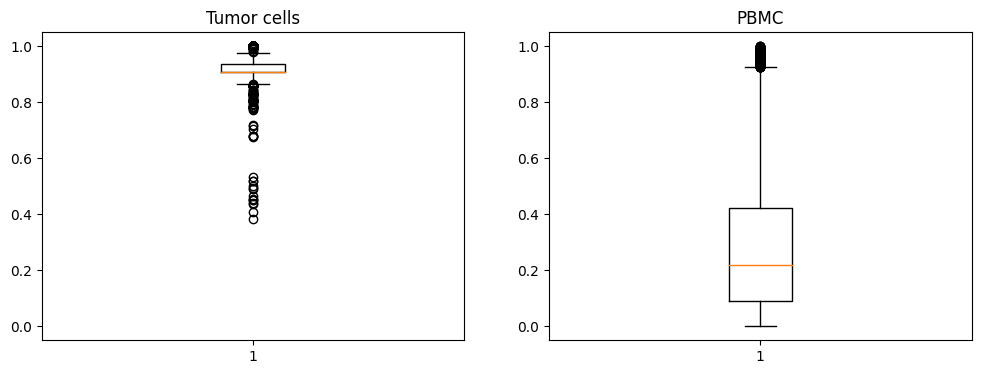

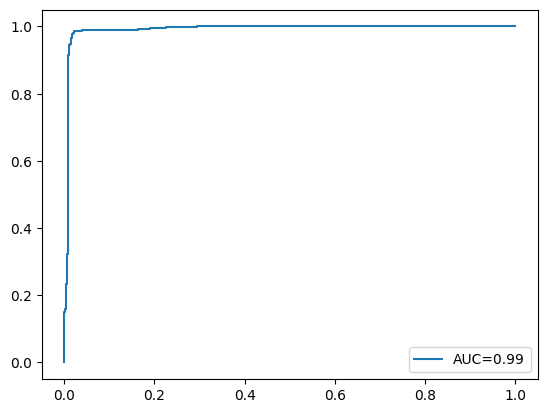

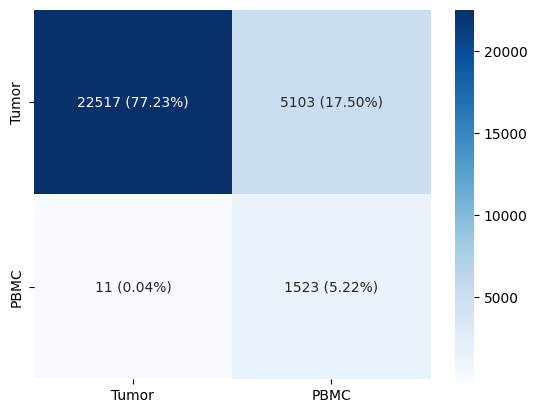

In [32]:
vis = Visualisation(lgbm_estimators, cut_by_mean_max_test_data, data_object.test_classes)
vis.plot_predictions_boxplot(cancer_title="Tumor cells", healthy_title="PBMC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="Tumor", healthy_category="PBMC")

In [33]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(lgbm_estimators, cut_by_mean_max_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 66


In [34]:
lgbm_model_object = Model(
    lgbm_clf,
    reduced_train_data,
    data_object.train_classes,
    reduced_test_data,
    data_object.test_classes,
    3,
)
lgbm_estimators = lgbm_model_object.main_cycle()

Validation balanced accuracy 0.9248420661464141
Training balanced accuracy 1.0

Validation roc auc 0.9801653660349312
Training roc auc 1.0

Validation precision 0.9703488788595171
Training precision 1.0

Validation recall 0.9565217391304347
Training recall 1.0

Validation f1 0.9632045373980858
Training f1 1.0



In [35]:
lgbm_model_object.display_test_results()

Test balanced accuracy 0.8755228105023759

Test roc auc 0.9791841440345963

Test precision 0.27204793037651603

Test recall 0.9850065189048239

Test f1 score 0.40020514617148856


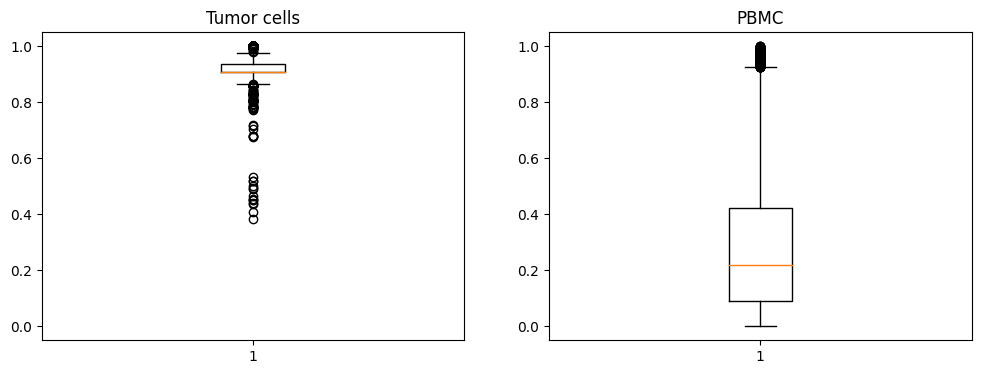

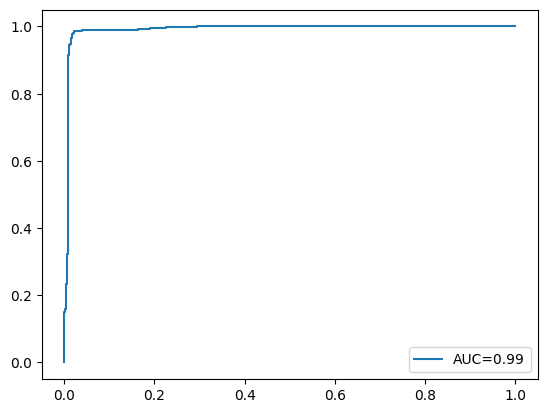

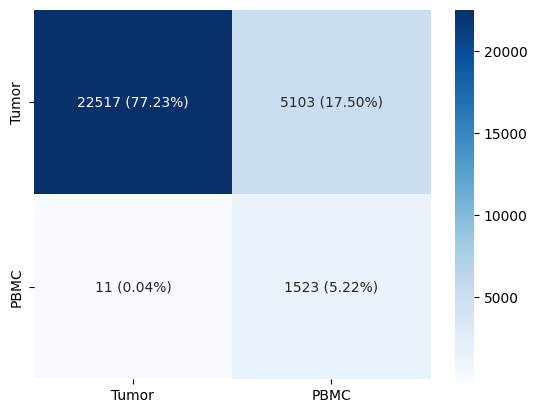

In [36]:
vis = Visualisation(lgbm_estimators, reduced_test_data, data_object.test_classes)
vis.plot_predictions_boxplot(cancer_title="Tumor cells", healthy_title="PBMC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="Tumor", healthy_category="PBMC")

### Cut by mean with classes

In [37]:
lgbm_model_object = Model(
    lgbm_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_classes,
    cut_by_mean_with_classes_test_data,
    data_object.test_classes,
    3,
)
lgbm_estimators = lgbm_model_object.main_cycle()

Validation balanced accuracy 0.8913507989594947
Training balanced accuracy 1.0

Validation roc auc 0.9746841322928278
Training roc auc 1.0

Validation precision 0.9621816455670742
Training precision 1.0

Validation recall 0.9130434782608695
Training recall 1.0

Validation f1 0.93621015999189
Training f1 1.0



In [38]:
lgbm_model_object.display_test_results()

Test balanced accuracy 0.8964214548282222

Test roc auc 0.9952660839775924

Test precision 0.25968141433407027

Test recall 0.9984789222077358

Test f1 score 0.3964564732880917


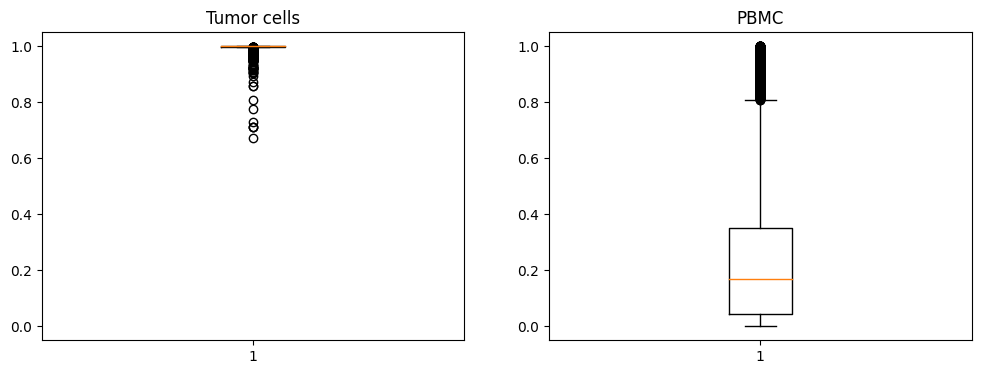

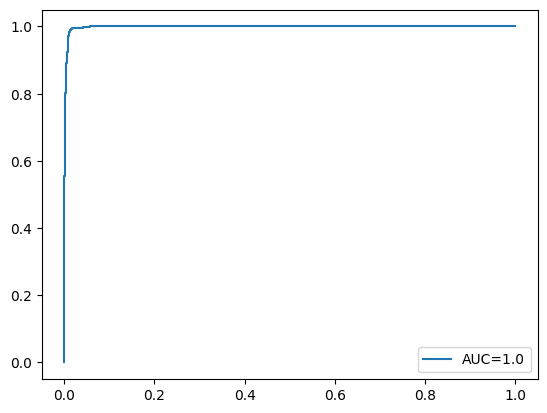

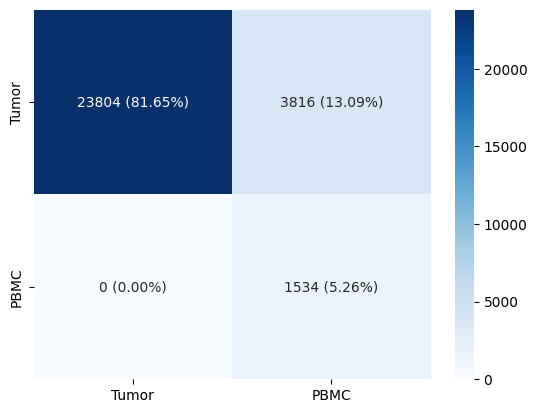

In [39]:
vis = Visualisation(lgbm_estimators, cut_by_mean_with_classes_test_data, data_object.test_classes)
vis.plot_predictions_boxplot(cancer_title="Tumor cells", healthy_title="PBMC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="Tumor", healthy_category="PBMC")

In [40]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(lgbm_estimators, cut_by_mean_with_classes_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 67


In [41]:
lgbm_model_object = Model(
    lgbm_clf,
    reduced_train_data,
    data_object.train_classes,
    reduced_test_data,
    data_object.test_classes,
    3,
)
lgbm_estimators = lgbm_model_object.main_cycle()

Validation balanced accuracy 0.8913507989594947
Training balanced accuracy 1.0

Validation roc auc 0.9746841322928278
Training roc auc 1.0

Validation precision 0.9621816455670742
Training precision 1.0

Validation recall 0.9130434782608695
Training recall 1.0

Validation f1 0.93621015999189
Training f1 1.0



In [42]:
lgbm_model_object.display_test_results()

Test balanced accuracy 0.8964214548282222

Test roc auc 0.9952660839775924

Test precision 0.25968141433407027

Test recall 0.9984789222077358

Test f1 score 0.3964564732880917


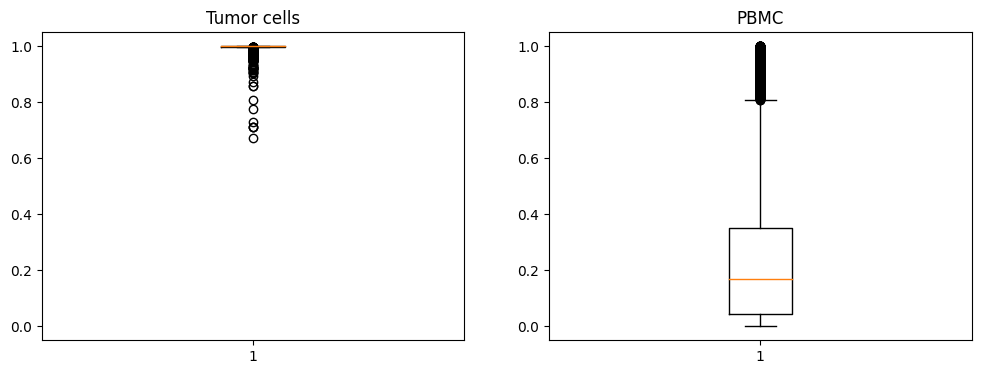

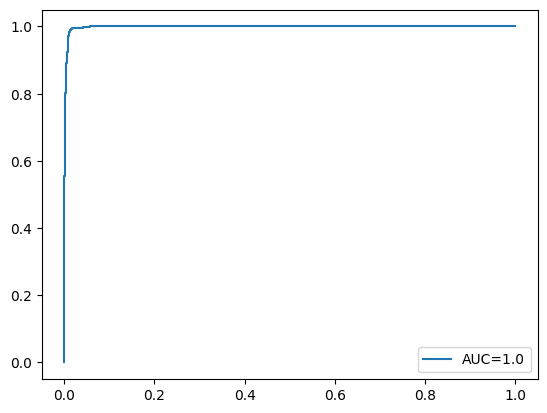

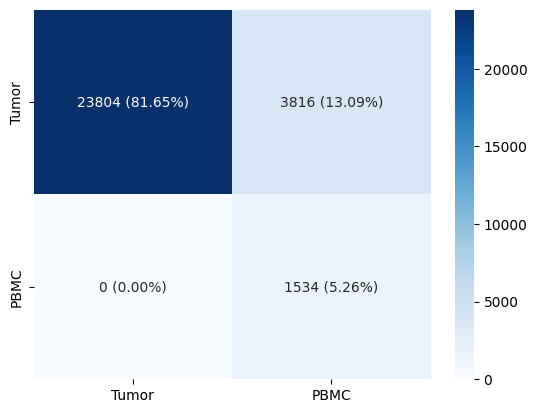

In [43]:
vis = Visualisation(lgbm_estimators, reduced_test_data, data_object.test_classes)
vis.plot_predictions_boxplot(cancer_title="Tumor cells", healthy_title="PBMC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="Tumor", healthy_category="PBMC")

### XGBoost

In [44]:
healthy_cells_train_indices = np.where(data_object.train_classes == 0)[0]
cancer_cells_train_indices = np.where(data_object.train_classes == 1)[0]

class_weight = len(healthy_cells_train_indices) / len(cancer_cells_train_indices)

xgb_clf = XGBClassifier(
    booster="gbtree",
    eta=0.2,
    #min_child_weight=4,  # Jedyna zmiana w porownaniu do poprzedniego podzialu
    max_depth=8,
    gamma=0.01,   
    scale_pos_weight=class_weight,
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [45]:
xgboost_model_object = Model(
    xgb_clf,
    cut_by_mean_max_train_data,
    data_object.train_classes,
    cut_by_mean_max_test_data,
    data_object.test_classes,
    3,
)
xgboost_estimators = xgboost_model_object.main_cycle()

Validation balanced accuracy 0.8969249349684132
Training balanced accuracy 0.9909420289855072

Validation roc auc 0.9731047937569678
Training roc auc 1.0

Validation precision 0.9690058479532163
Training precision 1.0

Validation recall 0.8985507246376812
Training recall 0.9818840579710145

Validation f1 0.9310134310134309
Training f1 0.9907710989678202



In [46]:
xgboost_model_object.display_test_results()

Test balanced accuracy 0.7821867975419812

Test roc auc 0.9856168421248072

Test precision 0.4180928941091622

Test recall 0.7081703607127338

Test f1 score 0.3038151637733146


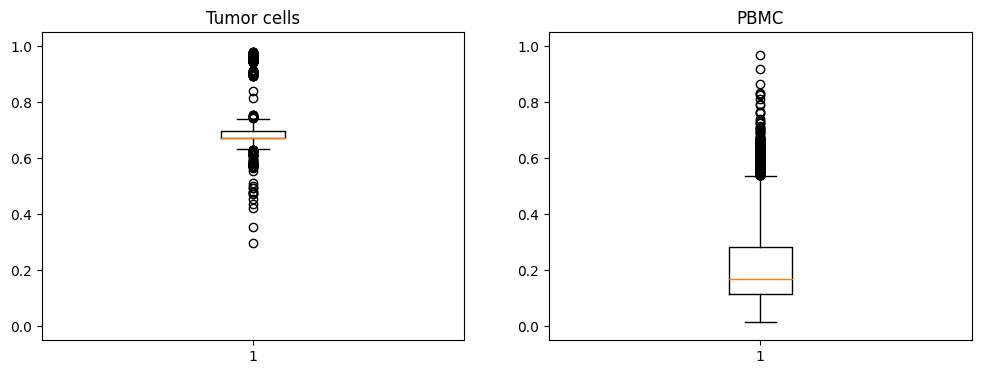

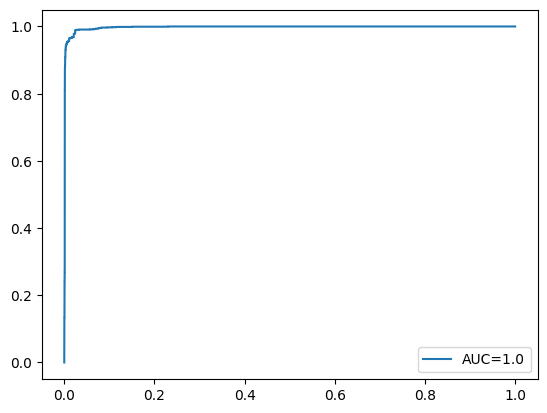

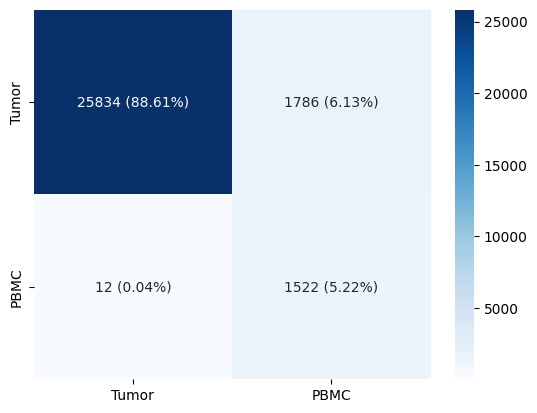

In [47]:
vis = Visualisation(xgboost_estimators, cut_by_mean_max_test_data, data_object.test_classes)
vis.plot_predictions_boxplot(cancer_title="Tumor cells", healthy_title="PBMC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="Tumor", healthy_category="PBMC")

In [48]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(xgboost_estimators, cut_by_mean_max_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 23


In [49]:
xgboost_model_object = Model(
    xgb_clf,
    reduced_train_data,
    data_object.train_classes,
    reduced_test_data,
    data_object.test_classes,
    3,
)
xgboost_estimators = xgboost_model_object.main_cycle()

Validation balanced accuracy 0.8969249349684132
Training balanced accuracy 0.9909420289855072

Validation roc auc 0.9742196209587514
Training roc auc 1.0

Validation precision 0.9690058479532163
Training precision 1.0

Validation recall 0.8985507246376812
Training recall 0.9818840579710145

Validation f1 0.9310134310134309
Training f1 0.9907710989678202



In [50]:
xgboost_model_object.display_test_results()

Test balanced accuracy 0.7792119315941406

Test roc auc 0.9854200319352383

Test precision 0.4133014788080714

Test recall 0.7083876575401998

Test f1 score 0.29726894348247207


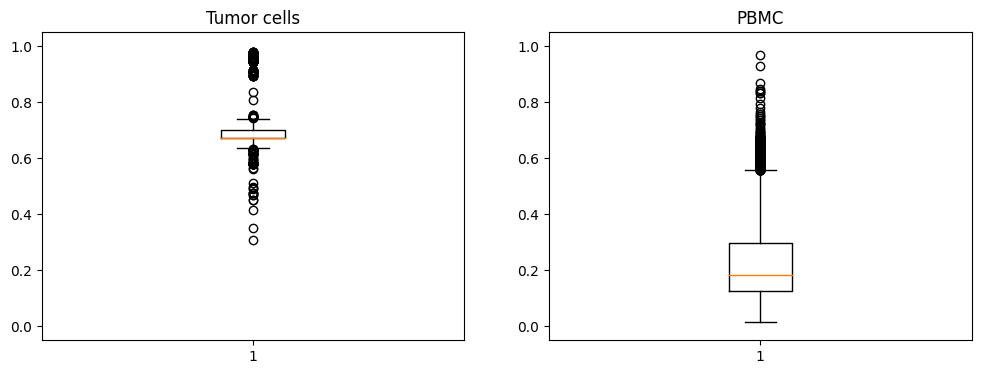

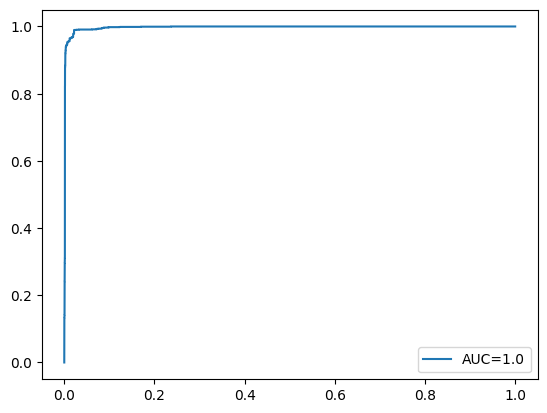

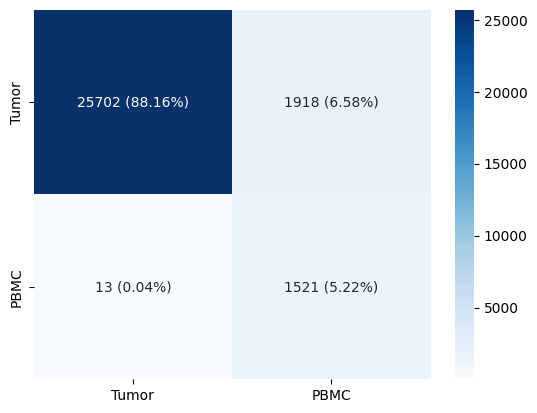

In [51]:
vis = Visualisation(xgboost_estimators, reduced_test_data, data_object.test_classes)
vis.plot_predictions_boxplot(cancer_title="Tumor cells", healthy_title="PBMC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="Tumor", healthy_category="PBMC")

### Cut by mean with classes

In [52]:
xgboost_model_object = Model(
    xgb_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_classes,
    cut_by_mean_with_classes_test_data,
    data_object.test_classes,
    3,
)
xgboost_estimators = xgboost_model_object.main_cycle()

Validation balanced accuracy 0.9298123374210331
Training balanced accuracy 1.0

Validation roc auc 0.9757525083612041
Training roc auc 1.0

Validation precision 0.9846723044397464
Training precision 1.0

Validation recall 0.9130434782608696
Training recall 1.0

Validation f1 0.9473015053022803
Training f1 1.0



In [53]:
xgboost_model_object.display_test_results()

Test balanced accuracy 0.9416785463990879

Test roc auc 0.9947698415920289

Test precision 0.39628338780631295

Test recall 0.9986962190352021

Test f1 score 0.5434194789691578


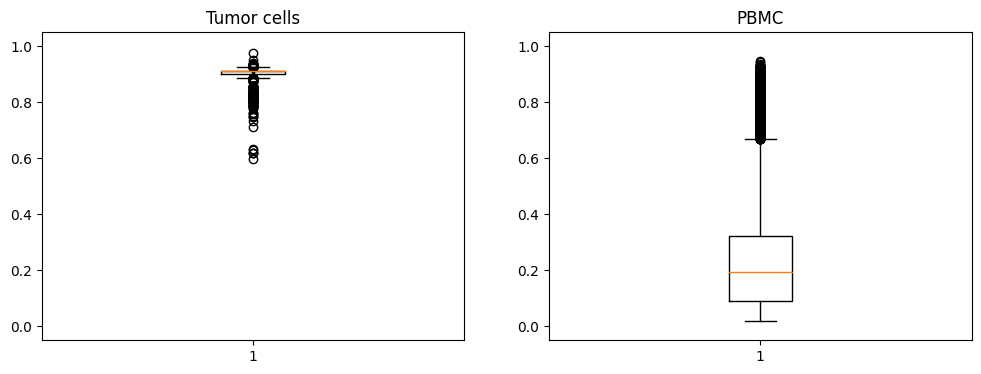

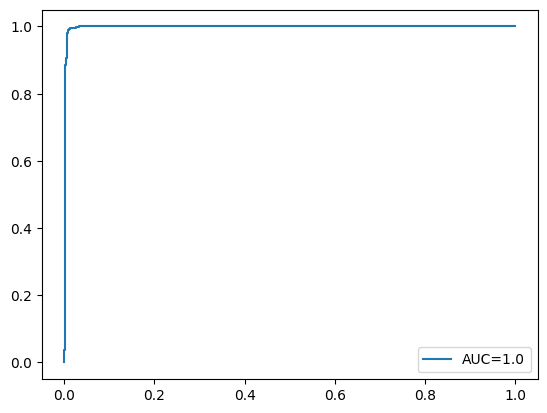

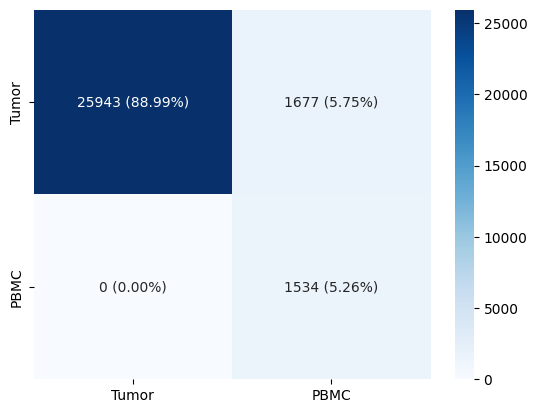

In [54]:
vis = Visualisation(xgboost_estimators, cut_by_mean_with_classes_test_data, data_object.test_classes)
vis.plot_predictions_boxplot(cancer_title="Tumor cells", healthy_title="PBMC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="Tumor", healthy_category="PBMC")

In [55]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(xgboost_estimators, cut_by_mean_with_classes_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 37


In [56]:
xgboost_model_object = Model(
    xgb_clf,
    reduced_train_data,
    data_object.train_classes,
    reduced_test_data,
    data_object.test_classes,
    3,
)
xgboost_estimators = xgboost_model_object.main_cycle()

Validation balanced accuracy 0.9298123374210331
Training balanced accuracy 0.9981884057971014

Validation roc auc 0.974544778892605
Training roc auc 1.0

Validation precision 0.9846723044397464
Training precision 1.0

Validation recall 0.9130434782608696
Training recall 0.9963768115942028

Validation f1 0.9473015053022803
Training f1 0.9981785063752276



In [57]:
xgboost_model_object.display_test_results()

Test balanced accuracy 0.9417087177724888

Test roc auc 0.9944427831176257

Test precision 0.3972457669083265

Test recall 0.9986962190352021

Test f1 score 0.5440831942667929


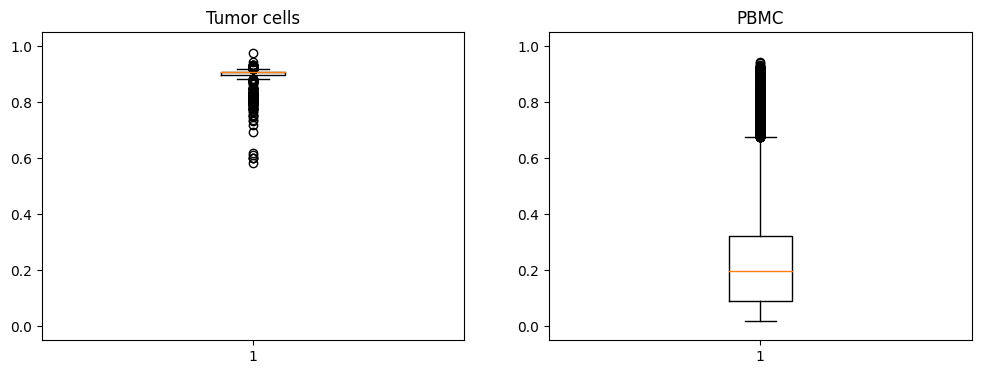

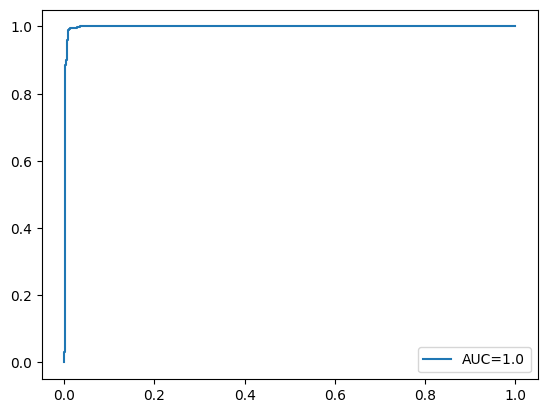

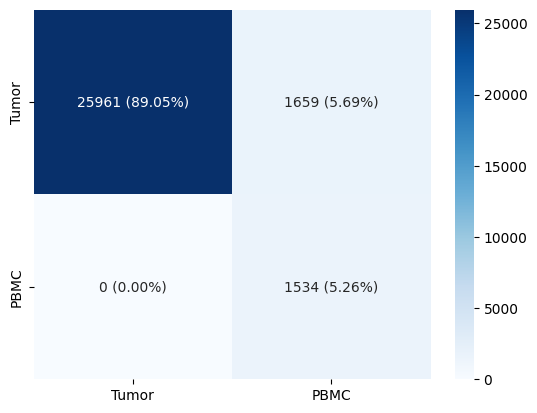

In [58]:
vis = Visualisation(xgboost_estimators, reduced_test_data, data_object.test_classes)
vis.plot_predictions_boxplot(cancer_title="Tumor cells", healthy_title="PBMC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="Tumor", healthy_category="PBMC")

### Random Forest

In [59]:
rf_clf = RandomForestClassifier(  
    criterion="log_loss",
    n_estimators=2000,
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [60]:
rf_model_object = Model(
    rf_clf,
    cut_by_mean_max_train_data,
    data_object.train_classes,
    cut_by_mean_max_test_data,
    data_object.test_classes,
    3,
)
rf_estimators = rf_model_object.main_cycle()

Validation balanced accuracy 0.9320884429580082
Training balanced accuracy 1.0

Validation roc auc 0.9929394277220364
Training roc auc 1.0

Validation precision 0.9711476466795617
Training precision 1.0

Validation recall 0.9710144927536232
Training recall 1.0

Validation f1 0.9708482676224612
Training f1 1.0



In [61]:
rf_model_object.display_test_results()

Test balanced accuracy 0.794478638667632

Test roc auc 0.9987557671773851

Test precision 0.19712280682478078

Test recall 1.0

Test f1 score 0.3037962998822363


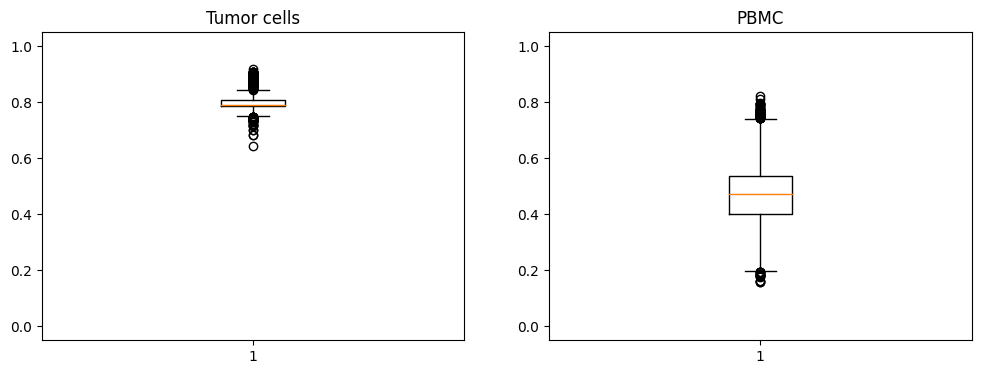

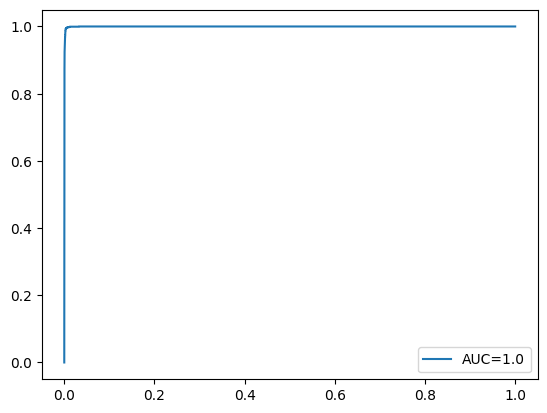

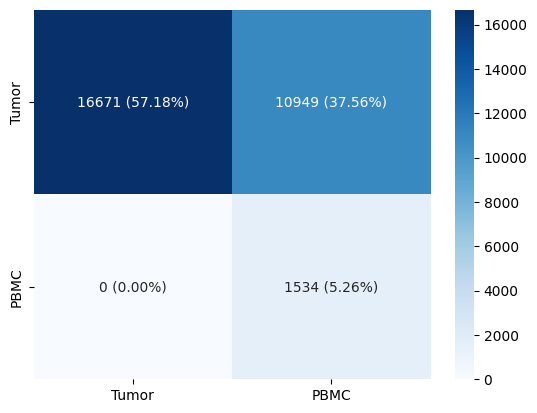

In [62]:
vis = Visualisation(rf_estimators, cut_by_mean_max_test_data, data_object.test_classes)
vis.plot_predictions_boxplot(cancer_title="Tumor cells", healthy_title="PBMC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="Tumor", healthy_category="PBMC")

In [63]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(rf_estimators, cut_by_mean_max_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 67


In [64]:
rf_model_object = Model(
    rf_clf,
    reduced_train_data,
    data_object.train_classes,
    reduced_test_data,
    data_object.test_classes,
    3,
)
rf_estimators = rf_model_object.main_cycle()

Validation balanced accuracy 0.9320884429580082
Training balanced accuracy 1.0

Validation roc auc 0.9929394277220364
Training roc auc 1.0

Validation precision 0.9711476466795617
Training precision 1.0

Validation recall 0.9710144927536232
Training recall 1.0

Validation f1 0.9708482676224612
Training f1 1.0



In [65]:
rf_model_object.display_test_results()

Test balanced accuracy 0.794478638667632

Test roc auc 0.9987557671773851

Test precision 0.19712280682478078

Test recall 1.0

Test f1 score 0.3037962998822363


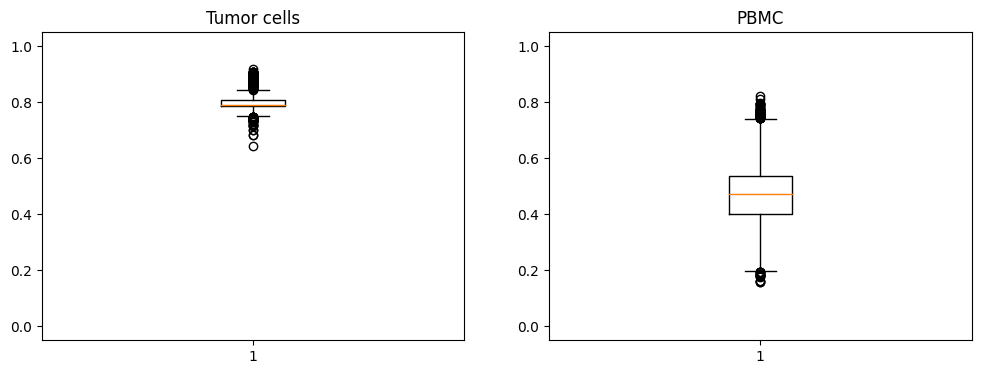

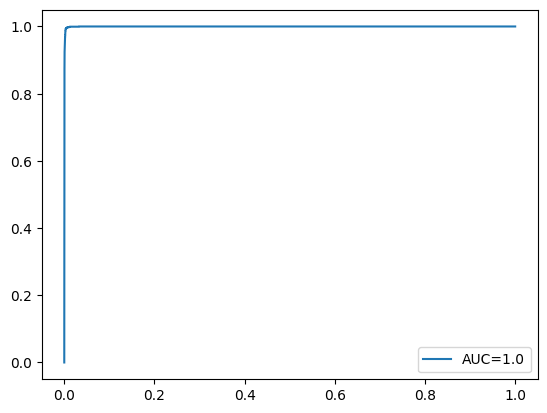

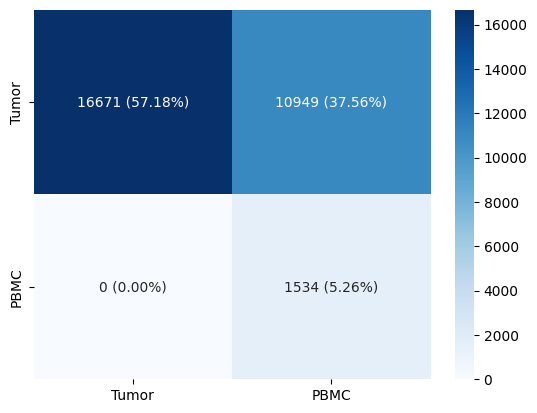

In [66]:
vis = Visualisation(rf_estimators, reduced_test_data, data_object.test_classes)
vis.plot_predictions_boxplot(cancer_title="Tumor cells", healthy_title="PBMC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="Tumor", healthy_category="PBMC")

### Cut by mean with classes

In [67]:
rf_model_object = Model(
    rf_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_classes,
    cut_by_mean_with_classes_test_data,
    data_object.test_classes,
    3,
)
rf_estimators = rf_model_object.main_cycle()

Validation balanced accuracy 0.8906075808249722
Training balanced accuracy 1.0

Validation roc auc 0.9823950204384987
Training roc auc 1.0

Validation precision 0.9448696145124718
Training precision 1.0

Validation recall 0.9927536231884058
Training recall 1.0

Validation f1 0.9681970884658454
Training f1 1.0



In [68]:
rf_model_object.display_test_results()

Test balanced accuracy 0.8097694907072169

Test roc auc 0.9940762815713722

Test precision 0.1287487601345325

Test recall 1.0

Test f1 score 0.22789356514840128


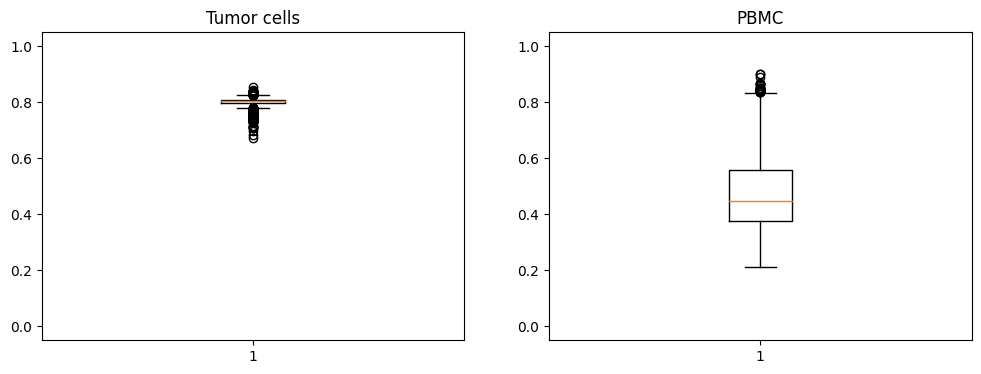

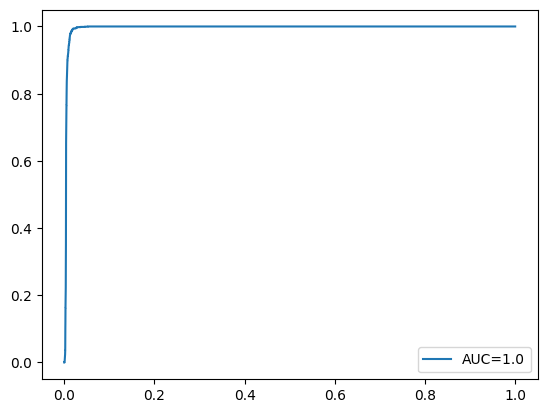

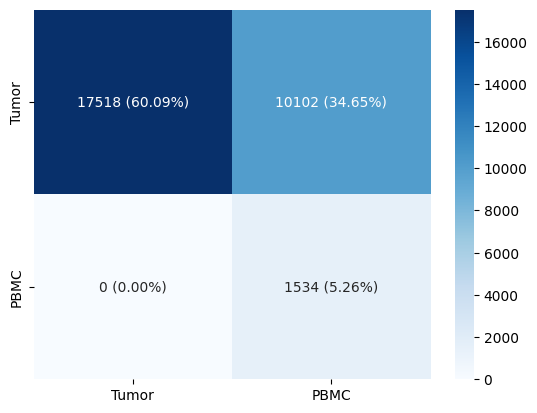

In [69]:
vis = Visualisation(rf_estimators, cut_by_mean_with_classes_test_data, data_object.test_classes)
vis.plot_predictions_boxplot(cancer_title="Tumor cells", healthy_title="PBMC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="Tumor", healthy_category="PBMC")

In [70]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(rf_estimators, cut_by_mean_with_classes_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 67


In [71]:
rf_model_object = Model(
    rf_clf,
    reduced_train_data,
    data_object.train_classes,
    reduced_test_data,
    data_object.test_classes,
    3,
)
rf_estimators = rf_model_object.main_cycle()

Validation balanced accuracy 0.8906075808249722
Training balanced accuracy 1.0

Validation roc auc 0.9823950204384987
Training roc auc 1.0

Validation precision 0.9448696145124718
Training precision 1.0

Validation recall 0.9927536231884058
Training recall 1.0

Validation f1 0.9681970884658454
Training f1 1.0



In [72]:
rf_model_object.display_test_results()

Test balanced accuracy 0.8097694907072169

Test roc auc 0.9940762815713722

Test precision 0.1287487601345325

Test recall 1.0

Test f1 score 0.22789356514840128


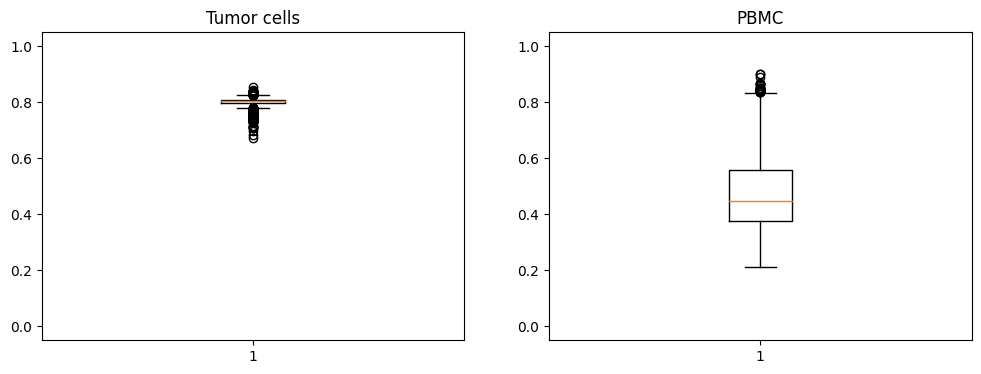

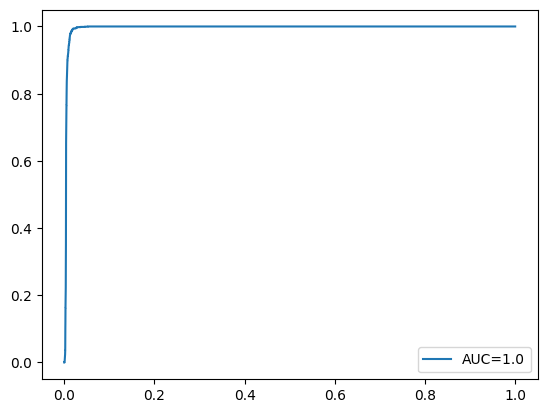

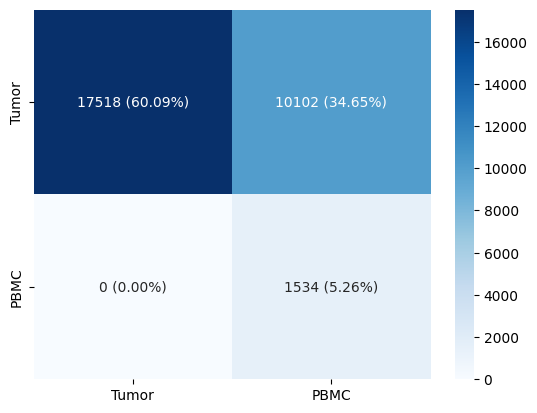

In [73]:
vis = Visualisation(rf_estimators, reduced_test_data, data_object.test_classes)
vis.plot_predictions_boxplot(cancer_title="Tumor cells", healthy_title="PBMC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="Tumor", healthy_category="PBMC")

### Balanced Random Forest

In [74]:
brf_clf = BalancedRandomForestClassifier(
    n_estimators=2000,
    class_weight="balanced",
    criterion="entropy",
    oob_score=True,  
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [75]:
brf_model_object = Model(
    brf_clf,
    cut_by_mean_max_train_data,
    data_object.train_classes,
    cut_by_mean_max_test_data,
    data_object.test_classes,
    3,
)
brf_estimators = brf_model_object.main_cycle()

Validation balanced accuracy 0.9565217391304347
Training balanced accuracy 0.9746376811594203

Validation roc auc 0.9877833519137867
Training roc auc 1.0

Validation precision 1.0
Training precision 1.0

Validation recall 0.9130434782608695
Training recall 0.9492753623188407

Validation f1 0.9539056571442558
Training f1 0.9739281961007489



In [76]:
brf_model_object.display_test_results()

Test balanced accuracy 0.9931017226084053

Test roc auc 0.9992388041782672

Test precision 0.9020240741843066

Test recall 0.9923946110386789

Test f1 score 0.9442301320284628


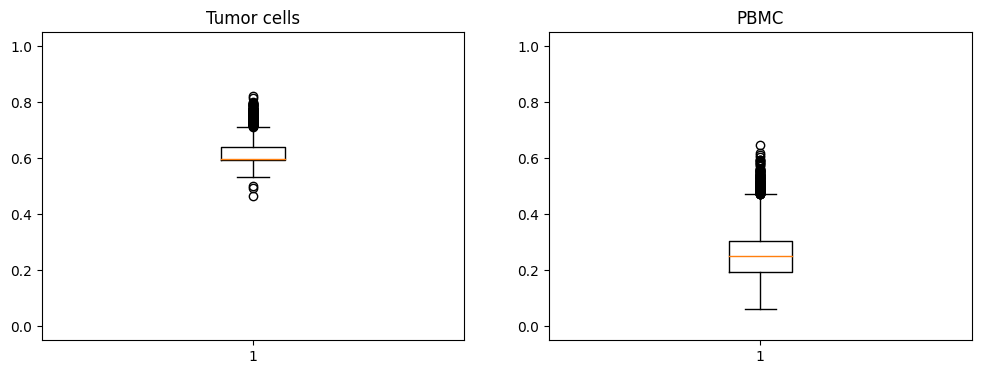

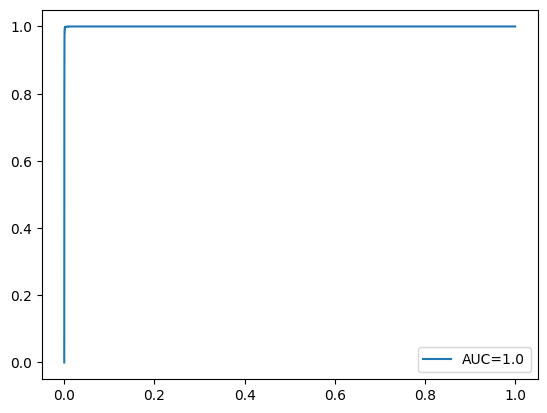

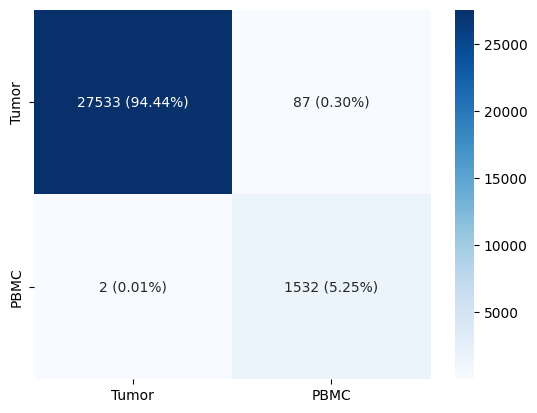

In [77]:
vis = Visualisation(brf_estimators, cut_by_mean_max_test_data, data_object.test_classes)
vis.plot_predictions_boxplot(cancer_title="Tumor cells", healthy_title="PBMC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="Tumor", healthy_category="PBMC")

In [78]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(brf_estimators, cut_by_mean_max_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 67


In [79]:
brf_model_object = Model(
    brf_clf,
    reduced_train_data,
    data_object.train_classes,
    reduced_test_data,
    data_object.test_classes,
    3,
)
brf_estimators = brf_model_object.main_cycle()

Validation balanced accuracy 0.9565217391304347
Training balanced accuracy 0.9746376811594203

Validation roc auc 0.9877833519137867
Training roc auc 1.0

Validation precision 1.0
Training precision 1.0

Validation recall 0.9130434782608695
Training recall 0.9492753623188407

Validation f1 0.9539056571442558
Training f1 0.9739281961007489



In [80]:
brf_model_object.display_test_results()

Test balanced accuracy 0.9931017226084053

Test roc auc 0.9992388041782672

Test precision 0.9020240741843066

Test recall 0.9923946110386789

Test f1 score 0.9442301320284628


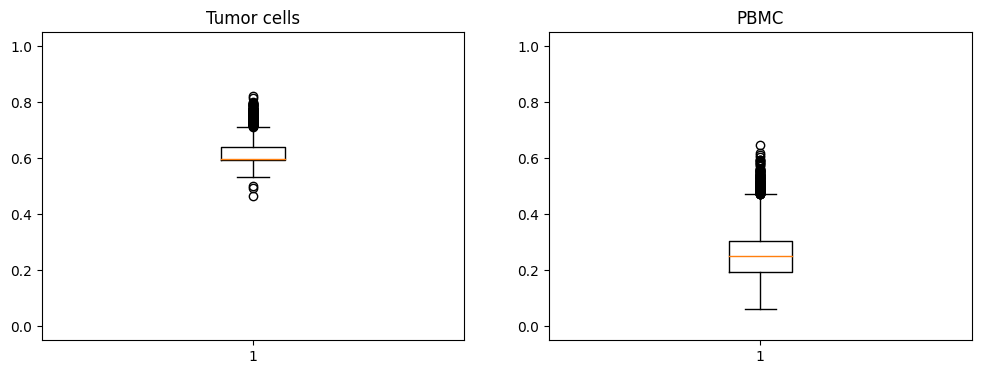

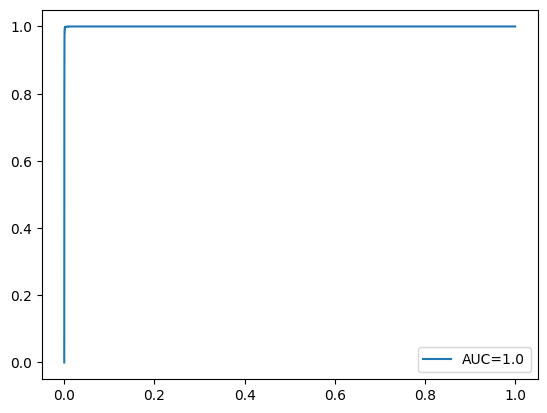

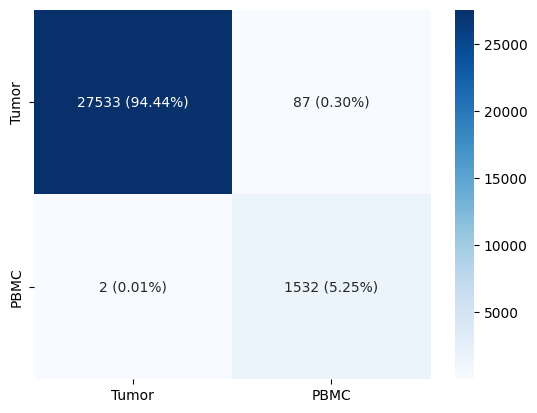

In [81]:
vis = Visualisation(brf_estimators, reduced_test_data, data_object.test_classes)
vis.plot_predictions_boxplot(cancer_title="Tumor cells", healthy_title="PBMC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="Tumor", healthy_category="PBMC")

### Cut by mean with classes

In [82]:
brf_model_object = Model(
    brf_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_classes,
    cut_by_mean_with_classes_test_data,
    data_object.test_classes,
    3,
)
brf_estimators = brf_model_object.main_cycle()

Validation balanced accuracy 0.9334355258268302
Training balanced accuracy 0.9800724637681159

Validation roc auc 0.9857859531772576
Training roc auc 1.0

Validation precision 0.9850168350168351
Training precision 1.0

Validation recall 0.9202898550724639
Training recall 0.9601449275362318

Validation f1 0.9509403602426859
Training f1 0.9796392892784755



In [83]:
brf_model_object.display_test_results()

Test balanced accuracy 0.9897234414027084

Test roc auc 0.9991565980033869

Test precision 0.744202721053875

Test recall 0.9986962190352021

Test f1 score 0.8523309644677716


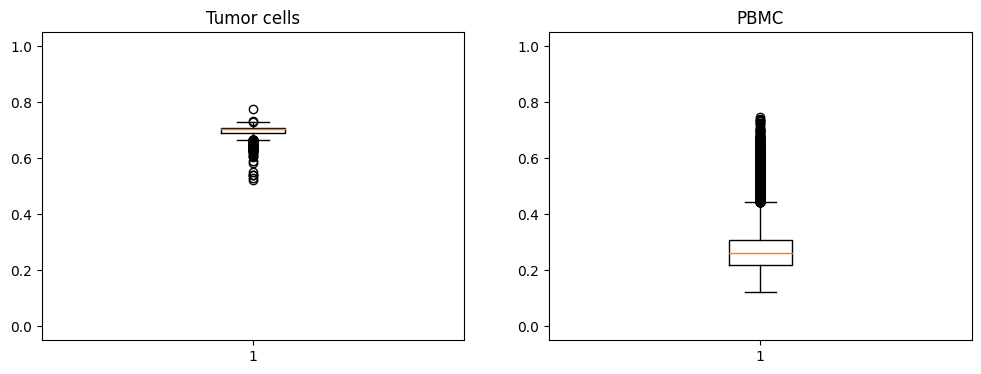

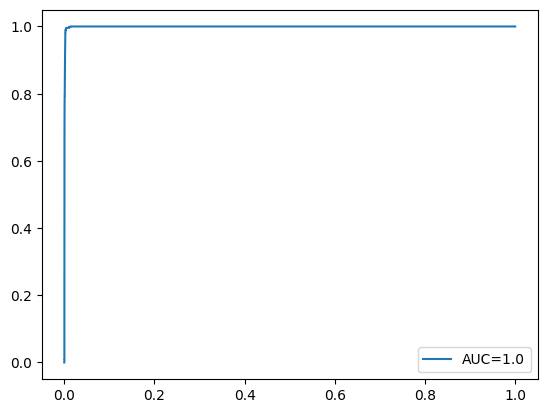

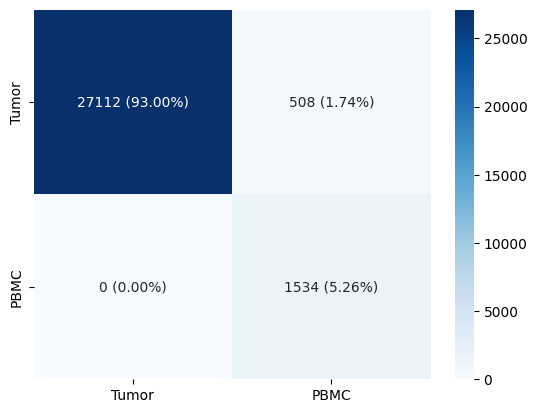

In [84]:
vis = Visualisation(brf_estimators, cut_by_mean_with_classes_test_data, data_object.test_classes)
vis.plot_predictions_boxplot(cancer_title="Tumor cells", healthy_title="PBMC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="Tumor", healthy_category="PBMC")

In [85]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(brf_estimators, cut_by_mean_with_classes_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 67


In [86]:
brf_model_object = Model(
    brf_clf,
    reduced_train_data,
    data_object.train_classes,
    reduced_test_data,
    data_object.test_classes,
    3,
)
brf_estimators = brf_model_object.main_cycle()

Validation balanced accuracy 0.9334355258268302
Training balanced accuracy 0.9800724637681159

Validation roc auc 0.9857859531772576
Training roc auc 1.0

Validation precision 0.9850168350168351
Training precision 1.0

Validation recall 0.9202898550724639
Training recall 0.9601449275362318

Validation f1 0.9509403602426859
Training f1 0.9796392892784755



In [87]:
brf_model_object.display_test_results()

Test balanced accuracy 0.9897234414027084

Test roc auc 0.9991565980033869

Test precision 0.744202721053875

Test recall 0.9986962190352021

Test f1 score 0.8523309644677716


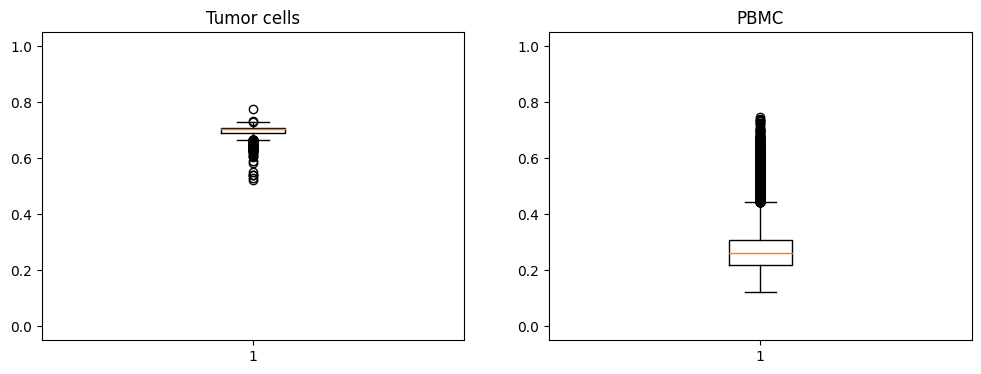

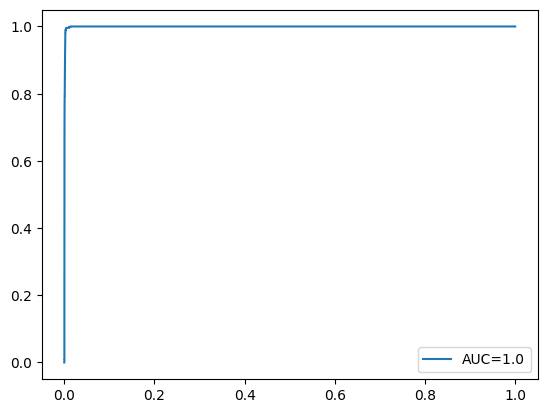

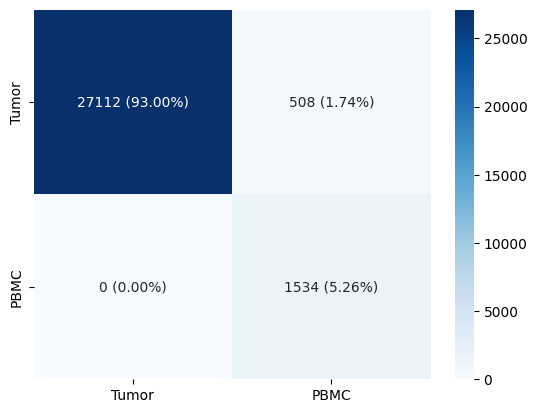

In [88]:
vis = Visualisation(brf_estimators, reduced_test_data, data_object.test_classes)
vis.plot_predictions_boxplot(cancer_title="Tumor cells", healthy_title="PBMC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="Tumor", healthy_category="PBMC")